In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as Fn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import numpy as np
import random
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from tqdm import tqdm
from patchEmbedding import PatchEmbedding
from blocks import FeedForward, TransformerEncoder
from vit import VisionTransformer

device = torch.device("cpu")
# # if torch.cuda.is_available():
# #     device =  torch.device("cuda")
# # elif torch.mps.is_available():
# #     device =  torch.device("mps")
# # else:
# #     device = torch.device("cpu")

# # mps has some issue running hence changed it

print(f"Device is {device}")






Device is cpu


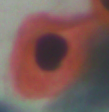

torch.Size([3, 112, 109])


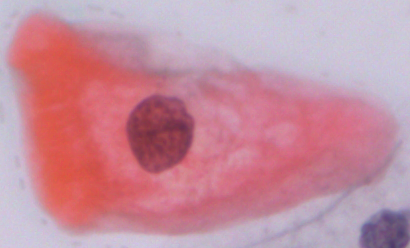

torch.Size([3, 248, 410])


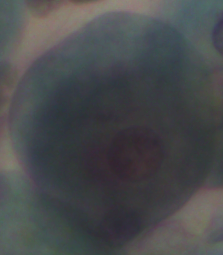

torch.Size([3, 255, 223])


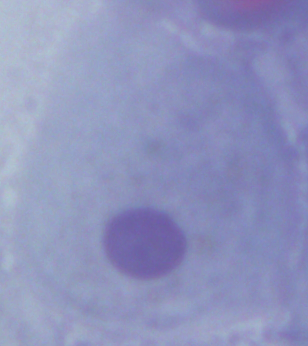

torch.Size([3, 346, 308])


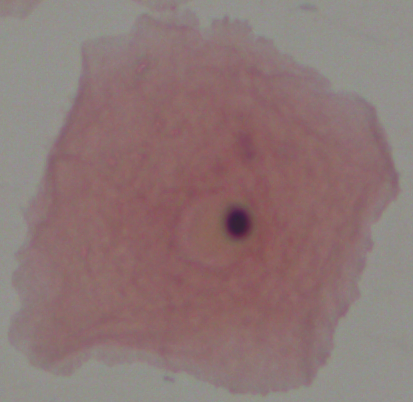

torch.Size([3, 402, 413])


In [6]:
from PIL import Image
import torchvision.transforms as transforms
import torch


def showImage(imagePath):
    image = Image.open(imagePath).convert("RGB")
    display(image)
    transform = transforms.ToTensor()
    tensor_image = transform(image)
    print(tensor_image.shape)

showImage("data/im_Dyskeratotic/001_01.bmp")
showImage("data/im_Koilocytotic/001_01.bmp")
showImage("data/im_Metaplastic/001_01.bmp")
showImage("data/im_Parabasal/001_01.bmp")
showImage("data/im_Superficial-Intermediate/001_01.bmp")

In [7]:
IMAGE_SIZE = 256
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = datasets.ImageFolder("data", transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

trainLoader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testLoader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
model = VisionTransformer(imageSize=IMAGE_SIZE, patchSize=16, inChannels=3, numClasses=5, embedDim=64, numLayers=5, numHeads=4, mlpDimension=128, drop_rate=0.2)
model.to(device)
lossFn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
epochs = 30

In [13]:
torch.autograd.set_detect_anomaly(True)
# torch.Tensor.view = torch.Tensor.reshape  # ONLY during debugging


model.train()
for each_epoch in range(epochs):
    train_loss = 0.0
    correctPred = 0
    total_train = 0
    validation_loss = 0.0
    train_accuracy = 0.0
    validation_accuracy = 0.0
    loop = tqdm(trainLoader, desc=f"Epoch [{each_epoch+1}/{epochs}]")
    for (batchX, batchY) in loop:
        batchX = batchX.to(device)
        batchY = batchY.to(device)
        # print(batchX.shape, batchY.shape)
        pred = model(batchX)
        pred.to(device)
        predClass = torch.argmax(pred, dim=1)
        # print(pred.shape)
        # print(batchY)
        # print(predClass)
        loss = lossFn(pred, batchY)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct = (predClass == batchY).sum().item()
        correctPred += correct
        total_train += batchY.size(0)
        train_loss += loss.item()

    train_loss = train_loss/len(trainLoader)
    train_accuracy = correctPred/total_train
    
    correctPred = 0
    total_valid = 0
    with torch.no_grad():
        for (batchX, batchY) in testLoader:
            batchX = batchX.to(device)
            batchY = batchY.to(device)
            pred = model(batchX)
            pred.to(device)
            predClass = torch.argmax(pred, dim=1)
            loss = lossFn(pred, batchY)
            validation_loss += loss.item()
            correct = (predClass == batchY).sum().item()
            correctPred += correct
            validation_loss += loss.item()
            total_valid += batchY.size(0)

    validation_loss = validation_loss/len(testLoader)
    validation_accuracy = correctPred/total_valid

    print(f"Training Loss: {train_loss} , Train Accuracy: {train_accuracy} , validation Loss: {validation_loss} , validation Accuracy: {validation_accuracy}")

        # break
    # break

Epoch [1/30]: 100%|██████████| 102/102 [00:52<00:00,  1.95it/s]


Training Loss: 1.197782373311473 , Train Accuracy: 0.5186786045075641 , validation Loss: 1.9700000377801747 , validation Accuracy: 0.6506172839506172


Epoch [2/30]: 100%|██████████| 102/102 [00:51<00:00,  1.96it/s]


Training Loss: 0.9434381629906449 , Train Accuracy: 0.6665637542451374 , validation Loss: 1.625052117384397 , validation Accuracy: 0.7246913580246913


Epoch [3/30]: 100%|██████████| 102/102 [00:52<00:00,  1.96it/s]


Training Loss: 0.8099911703782923 , Train Accuracy: 0.7033034887310898 , validation Loss: 1.4217914136556478 , validation Accuracy: 0.7666666666666667


Epoch [4/30]: 100%|██████████| 102/102 [00:55<00:00,  1.83it/s]


Training Loss: 0.7105507389003155 , Train Accuracy: 0.749922815683853 , validation Loss: 1.2890711220411153 , validation Accuracy: 0.7777777777777778


Epoch [5/30]: 100%|██████████| 102/102 [00:53<00:00,  1.91it/s]


Training Loss: 0.6468926262037427 , Train Accuracy: 0.7740043223217042 , validation Loss: 1.1517177797280824 , validation Accuracy: 0.8


Epoch [6/30]: 100%|██████████| 102/102 [00:53<00:00,  1.91it/s]


Training Loss: 0.5708257170284495 , Train Accuracy: 0.8014819388700216 , validation Loss: 1.0591801038155189 , validation Accuracy: 0.8111111111111111


Epoch [7/30]: 100%|██████████| 102/102 [00:54<00:00,  1.87it/s]


Training Loss: 0.5250266910183663 , Train Accuracy: 0.8209323865390553 , validation Loss: 0.9886862750236804 , validation Accuracy: 0.8246913580246914


Epoch [8/30]: 100%|██████████| 102/102 [00:55<00:00,  1.84it/s]


Training Loss: 0.49160023121272817 , Train Accuracy: 0.8283420808891633 , validation Loss: 0.9305555339042957 , validation Accuracy: 0.8444444444444444


Epoch [9/30]: 100%|██████████| 102/102 [00:53<00:00,  1.89it/s]


Training Loss: 0.4504310415655959 , Train Accuracy: 0.8431614695893794 , validation Loss: 0.8802724606715716 , validation Accuracy: 0.8395061728395061


Epoch [10/30]: 100%|██████████| 102/102 [00:55<00:00,  1.85it/s]


Training Loss: 0.4110872663703619 , Train Accuracy: 0.8561284347020686 , validation Loss: 0.8387451653297131 , validation Accuracy: 0.8469135802469135


Epoch [11/30]: 100%|██████████| 102/102 [00:54<00:00,  1.88it/s]


Training Loss: 0.3859555393311323 , Train Accuracy: 0.8644643408459401 , validation Loss: 0.7451654844559156 , validation Accuracy: 0.8679012345679012


Epoch [12/30]: 100%|██████████| 102/102 [00:53<00:00,  1.89it/s]


Training Loss: 0.35629307113441766 , Train Accuracy: 0.8737264587835751 , validation Loss: 0.7454069635042777 , validation Accuracy: 0.8703703703703703


Epoch [13/30]: 100%|██████████| 102/102 [00:54<00:00,  1.86it/s]


Training Loss: 0.3461201420309497 , Train Accuracy: 0.8731089842543995 , validation Loss: 0.7569256975100591 , validation Accuracy: 0.8641975308641975


Epoch [14/30]: 100%|██████████| 102/102 [00:52<00:00,  1.96it/s]


Training Loss: 0.32918615909475907 , Train Accuracy: 0.8808274158690954 , validation Loss: 0.7317931457207754 , validation Accuracy: 0.8629629629629629


Epoch [15/30]: 100%|██████████| 102/102 [00:54<00:00,  1.86it/s]


Training Loss: 0.3082522205716255 , Train Accuracy: 0.8981167026860142 , validation Loss: 0.6792807011650159 , validation Accuracy: 0.8814814814814815


Epoch [16/30]: 100%|██████████| 102/102 [00:56<00:00,  1.80it/s]


Training Loss: 0.28497002142317157 , Train Accuracy: 0.8999691262735412 , validation Loss: 0.6863469435618474 , validation Accuracy: 0.8827160493827161


Epoch [17/30]: 100%|██████████| 102/102 [00:57<00:00,  1.76it/s]


Training Loss: 0.2860780786357674 , Train Accuracy: 0.8971904908922507 , validation Loss: 0.6198517330563985 , validation Accuracy: 0.8925925925925926


Epoch [18/30]: 100%|██████████| 102/102 [00:55<00:00,  1.83it/s]


Training Loss: 0.2784043546108639 , Train Accuracy: 0.8999691262735412 , validation Loss: 0.6704957920771378 , validation Accuracy: 0.8851851851851852


Epoch [19/30]: 100%|██████████| 102/102 [00:54<00:00,  1.89it/s]


Training Loss: 0.26509403941385884 , Train Accuracy: 0.9055263970361223 , validation Loss: 0.6350039192117177 , validation Accuracy: 0.891358024691358


Epoch [20/30]: 100%|██████████| 102/102 [00:50<00:00,  2.01it/s]


Training Loss: 0.2541239510710333 , Train Accuracy: 0.9089225069465885 , validation Loss: 0.5512144949573737 , validation Accuracy: 0.9049382716049382


Epoch [21/30]: 100%|██████████| 102/102 [00:53<00:00,  1.89it/s]


Training Loss: 0.23517772182822227 , Train Accuracy: 0.9157147267675209 , validation Loss: 0.5868154638088666 , validation Accuracy: 0.9074074074074074


Epoch [22/30]: 100%|██████████| 102/102 [00:51<00:00,  1.97it/s]


Training Loss: 0.24646520877585693 , Train Accuracy: 0.9147885149737573 , validation Loss: 0.5674983305999866 , validation Accuracy: 0.8987654320987655


Epoch [23/30]: 100%|██████████| 102/102 [00:54<00:00,  1.86it/s]


Training Loss: 0.2208709949810131 , Train Accuracy: 0.9206545230009262 , validation Loss: 0.581910830277663 , validation Accuracy: 0.9012345679012346


Epoch [24/30]: 100%|██████████| 102/102 [00:51<00:00,  1.99it/s]


Training Loss: 0.2134230292822216 , Train Accuracy: 0.9218894720592775 , validation Loss: 0.5157551966034449 , validation Accuracy: 0.9185185185185185


Epoch [25/30]: 100%|██████████| 102/102 [00:50<00:00,  2.03it/s]


Training Loss: 0.20456990767635552 , Train Accuracy: 0.9289904291447978 , validation Loss: 0.4780185070748513 , validation Accuracy: 0.9185185185185185


Epoch [26/30]: 100%|██████████| 102/102 [00:49<00:00,  2.05it/s]


Training Loss: 0.19607284215881543 , Train Accuracy: 0.9351651744365544 , validation Loss: 0.5442972670380886 , validation Accuracy: 0.9111111111111111


Epoch [27/30]: 100%|██████████| 102/102 [00:49<00:00,  2.05it/s]


Training Loss: 0.19564816954673506 , Train Accuracy: 0.9299166409385613 , validation Loss: 0.5190138458632506 , validation Accuracy: 0.9098765432098765


Epoch [28/30]: 100%|██████████| 102/102 [00:50<00:00,  2.03it/s]


Training Loss: 0.19845499269956468 , Train Accuracy: 0.9314603272615004 , validation Loss: 0.49972157122997135 , validation Accuracy: 0.9222222222222223


Epoch [29/30]: 100%|██████████| 102/102 [00:50<00:00,  2.02it/s]


Training Loss: 0.17908661323142985 , Train Accuracy: 0.9410311824637234 , validation Loss: 0.4950958759738849 , validation Accuracy: 0.9234567901234568


Epoch [30/30]: 100%|██████████| 102/102 [00:50<00:00,  2.03it/s]


Training Loss: 0.1778036311232284 , Train Accuracy: 0.9388700216116085 , validation Loss: 0.4634379268838809 , validation Accuracy: 0.9209876543209876
